In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian, shape, get_angle, PD, eigen_decomposition)                              
from vgptools.utils_compilation import dfs_vgps_recomputed_poles
from vgptools.utils_APWPs import running_mean_APWP_shape, RM_stats, get_vgps_sampling_from_direction
from vgptools.utils_visualization import  RM_stats, plot_VGPs_and_APWP, plot_APWP_RM_ensemble, quantiles,plot_pole_A95, plot_pole, PC
np.random.seed(10)

## 1. Compile the VGPs 

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

In [3]:
# df_filtered_vgps, df_pole_compilation = dfs_vgps_recomputed_poles(data_path_VGP, by_study = True) # takes as many as poles as are described for one are
df_filtered_vgps = pd.read_csv(current_path +'/data/df_vgps_filtered.csv')

In [44]:
%%time

min_age = 0
max_age = 55
steps = [1,2,5,10] # [2,5,10] 
window_lengths = range(5,35,1)# [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25] # np.arange(10,35,5)

df_ensemble = pd.DataFrame(columns = ['step_size','window_lenght','n_training','mean_distance','std_distance'])

for step in steps:
    
    for window in window_lengths:

        for i in range(50):

            df_tmp = pd.DataFrame()

            train, test = train_test_split(df_filtered_vgps, test_size=0.3)        

            mean_distances = []
            std_distances = []

            # train_ = get_vgps_sampling_from_direction(train)
            # test_ = get_vgps_sampling_from_direction(test)

            RM_train_ = running_mean_APWP_shape(train, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window, step, max_age, min_age)
            RM_test_ = running_mean_APWP_shape(test, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window, step, max_age, min_age)

            distances = []

            for t in RM_train_.age.unique():

                df_train = RM_train_[RM_train_['age']==t]
                df_test = RM_test_[RM_test_['age']==t]

                try:
                    gcd = pmag.angle([df_train['plon'].iat[0], df_train['plat'].iat[0]],
                                     [df_test['plon'].iat[0], df_test['plat'].iat[0]])
                except:
                    continue

                distances.append(gcd)

            mean_distances.append(np.array(distances).mean())
            std_distances.append(np.array(distances).std())
            
            df_ensemble.loc[len(df_ensemble)] = [step, window, i, np.array(mean_distances).mean(), np.array(std_distances).mean()]

df_ensemble.head()

CPU times: user 32min 24s, sys: 5.6 s, total: 32min 29s
Wall time: 32min 30s


,step_size,window_lenght,n_training,mean_distance,std_distance
0,1.0,5.0,0.0,5.990340,4.728905
1,1.0,5.0,1.0,4.680125,4.710409
2,1.0,5.0,2.0,4.223769,4.366742
3,1.0,5.0,3.0,4.959071,3.954084
4,1.0,5.0,4.0,4.979481,4.240687


In [61]:
df = df_ensemble[df_ensemble['step_size']==2]

<AxesSubplot:xlabel='window_lenght', ylabel='std_distance'>

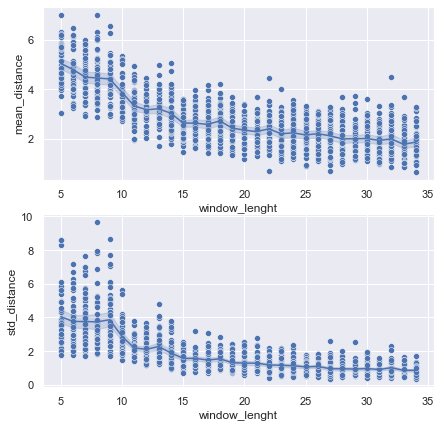

In [62]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(2,1, figsize=(7,7))

sns.scatterplot(x="window_lenght", y="mean_distance",  
             data=df, 
             ax = ax[0], legend = True, palette='GnBu_d')

sns.lineplot(x="window_lenght", y="mean_distance",  
             data=df, 
             ax = ax[0], legend = True, palette='GnBu_d')

sns.scatterplot(x="window_lenght", y="std_distance",
             data=df, 
             ax = ax[1], legend = True, palette='GnBu_d')

sns.lineplot(x="window_lenght", y="std_distance",
             data=df, 
             ax = ax[1], legend = True, palette='GnBu_d')

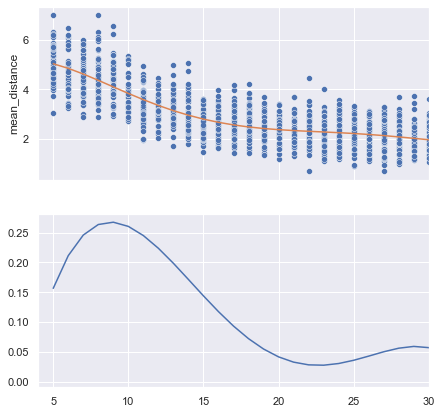

In [63]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

x = sorted(df['window_lenght'].unique())
y = df.groupby('window_lenght')['mean_distance'].mean().to_numpy() # splines cannot have repeated X's

s = UnivariateSpline(x, y, s = 1000, k = 5)

xs = sorted(df['window_lenght'].unique())
ys = s(xs)

xsd = sorted(df['window_lenght'].unique())
ysd = np.absolute(np.array([s.derivatives(x)[1] for x in xsd]))

fig, axs = plt.subplots(2, sharex =True, figsize=(7,7))

sns.set_theme(style="darkgrid")

sns.scatterplot(x="window_lenght", y="mean_distance",  
             data=df, 
             ax = axs[0], legend = True, palette='GnBu_d')

axs[0].plot(x, y, '.')
axs[0].plot(xs, ys)
axs[1].plot(xsd, ysd)

axs[1].set_xlim(4,30)

plt.show()

In [64]:
%%time

min_age = 0
max_age = 55
steps = [1,2,5,10] # [2,5,10] 
window_lengths = range(5,35,1)# [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25] # np.arange(10,35,5)

df_ensemble = pd.DataFrame(columns = ['step_size','window_lenght','n_training','mean_distance','std_distance'])

for step in steps:
    
    for window in window_lengths:

        for i in range(50):

            df_tmp = pd.DataFrame()

            train, test = train_test_split(df_filtered_vgps, test_size=0.4)        

            mean_distances = []
            std_distances = []

            # train_ = get_vgps_sampling_from_direction(train)
            # test_ = get_vgps_sampling_from_direction(test)

            RM_train_ = running_mean_APWP_shape(train, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window, step, max_age, min_age)
            RM_test_ = running_mean_APWP_shape(test, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window, step, max_age, min_age)

            distances = []

            for t in RM_train_.age.unique():

                df_train = RM_train_[RM_train_['age']==t]
                df_test = RM_test_[RM_test_['age']==t]

                try:
                    gcd = pmag.angle([df_train['plon'].iat[0], df_train['plat'].iat[0]],
                                     [df_test['plon'].iat[0], df_test['plat'].iat[0]])
                except:
                    continue

                distances.append(gcd)

            mean_distances.append(np.array(distances).mean())
            std_distances.append(np.array(distances).std())
            
            df_ensemble.loc[len(df_ensemble)] = [step, window, i, np.array(mean_distances).mean(), np.array(std_distances).mean()]

df_ensemble.head()

CPU times: user 32min 2s, sys: 4.8 s, total: 32min 7s
Wall time: 32min 8s


,step_size,window_lenght,n_training,mean_distance,std_distance
0,1.0,5.0,0.0,4.684471,3.261736
1,1.0,5.0,1.0,4.114228,3.492775
2,1.0,5.0,2.0,4.467060,3.441073
3,1.0,5.0,3.0,4.605057,2.463716
4,1.0,5.0,4.0,4.978746,4.570105


In [65]:
df = df_ensemble[df_ensemble['step_size']==2]

<AxesSubplot:xlabel='window_lenght', ylabel='std_distance'>

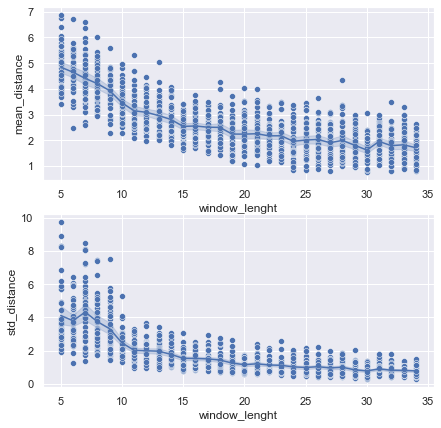

In [66]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(2,1, figsize=(7,7))

sns.scatterplot(x="window_lenght", y="mean_distance",  
             data=df, 
             ax = ax[0], legend = True, palette='GnBu_d')

sns.lineplot(x="window_lenght", y="mean_distance",  
             data=df, 
             ax = ax[0], legend = True, palette='GnBu_d')

sns.scatterplot(x="window_lenght", y="std_distance",
             data=df, 
             ax = ax[1], legend = True, palette='GnBu_d')

sns.lineplot(x="window_lenght", y="std_distance",
             data=df, 
             ax = ax[1], legend = True, palette='GnBu_d')

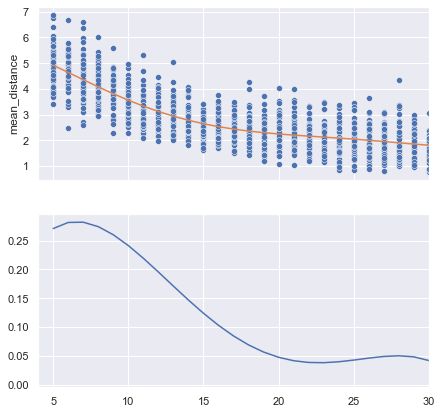

In [67]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

x = sorted(df['window_lenght'].unique())
y = df.groupby('window_lenght')['mean_distance'].mean().to_numpy() # splines cannot have repeated X's

s = UnivariateSpline(x, y, s = 1000, k = 5)

xs = sorted(df['window_lenght'].unique())
ys = s(xs)

xsd = sorted(df['window_lenght'].unique())
ysd = np.absolute(np.array([s.derivatives(x)[1] for x in xsd]))

fig, axs = plt.subplots(2, sharex =True, figsize=(7,7))

sns.set_theme(style="darkgrid")

sns.scatterplot(x="window_lenght", y="mean_distance",  
             data=df, 
             ax = axs[0], legend = True, palette='GnBu_d')

axs[0].plot(x, y, '.')
axs[0].plot(xs, ys)
axs[1].plot(xsd, ysd)

axs[1].set_xlim(4,30)

plt.show()